In [11]:
import os.path
import sys
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
import scoping
from utils.text import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

import pandas as pd
import numpy as np

import pickle
import scipy.sparse

import matplotlib.pyplot as plt

## Load the labelled data

In [2]:
seen_df = pd.read_csv('../data/0_labelled_documents.csv')

df = (seen_df
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
r_index = df[df["random_sample"]==1].index
physical_index = df[df['physical_tags']==1].index

## The relevant value is evenly distributed

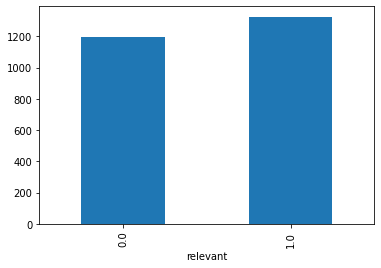

In [3]:
seen_df.groupby('relevant').size().plot.bar()

In [4]:
revectorize = True

X_exists = os.path.isfile(f'../data/X_{seen_df.shape[0]}.npz')

if revectorize is True or X_exists is False:
    print("running vectorisation again")
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=15, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        #tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("str"))   
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{seen_df.shape[0]}.npz', X)
else:
    print("loading feature matrix")
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz(f'../data/X_{seen_df.shape[0]}.npz')
        
X.shape

running vectorisation again


(2522, 7341)

In [5]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier


y = df['relevant']


from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title': 'SVM', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True)
    },
    {
        'title': "GB",
        'model': GradientBoostingClassifier(random_state=0)
    },
    {
        'title': "GB",
        'model': GradientBoostingClassifier(random_state=0, n_estimators=500)
    },
    {
        'title': "Adaboost",
        'model': AdaBoostClassifier()
    }
]

clf_models, df = lu.cross_validate_models(X, y, clf_models, seen_index, n_splits=6, df = df)

1
2
3
4
5
6


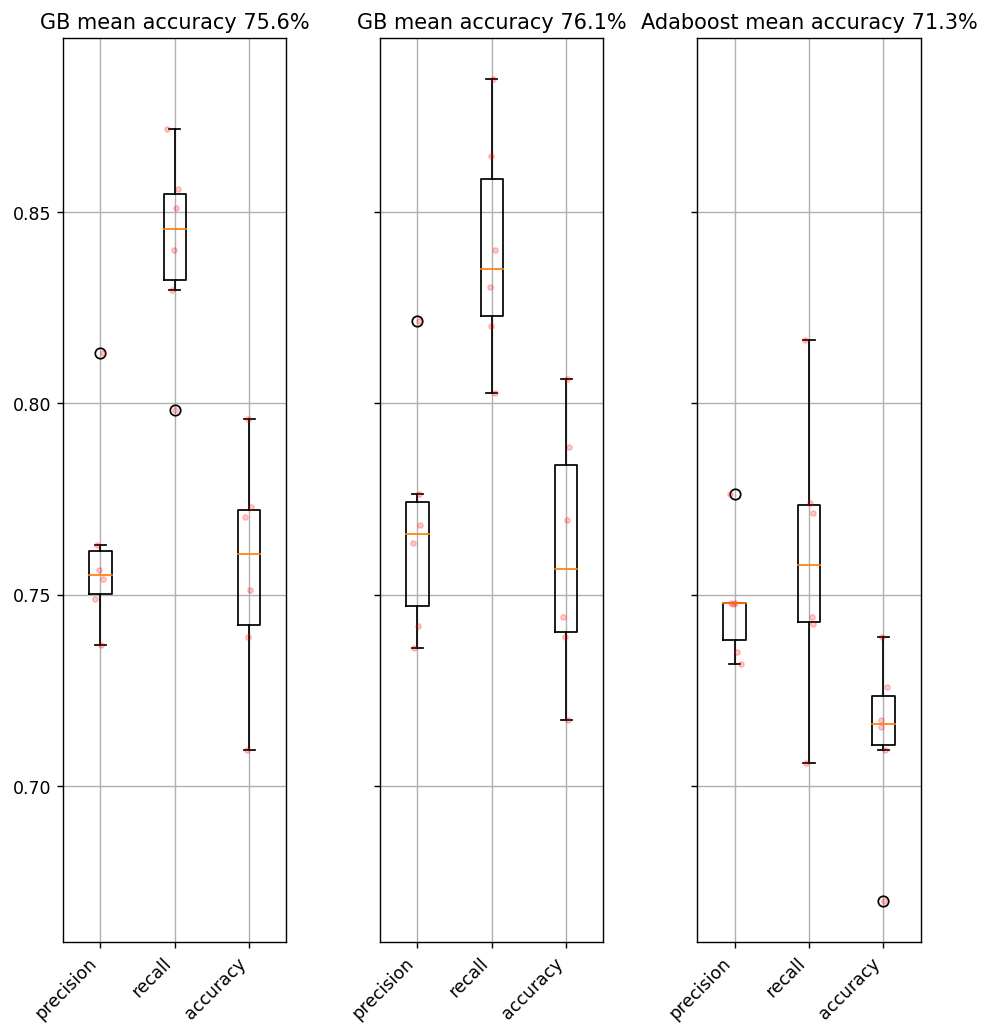

In [6]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

fig, axs = plt.subplots(1, len(clf_models[2:]),dpi=125,figsize=(8,8),sharey=True)              
lu.plot_model_output(clf_models[2:],  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
#fig.tight_layout()
#plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()

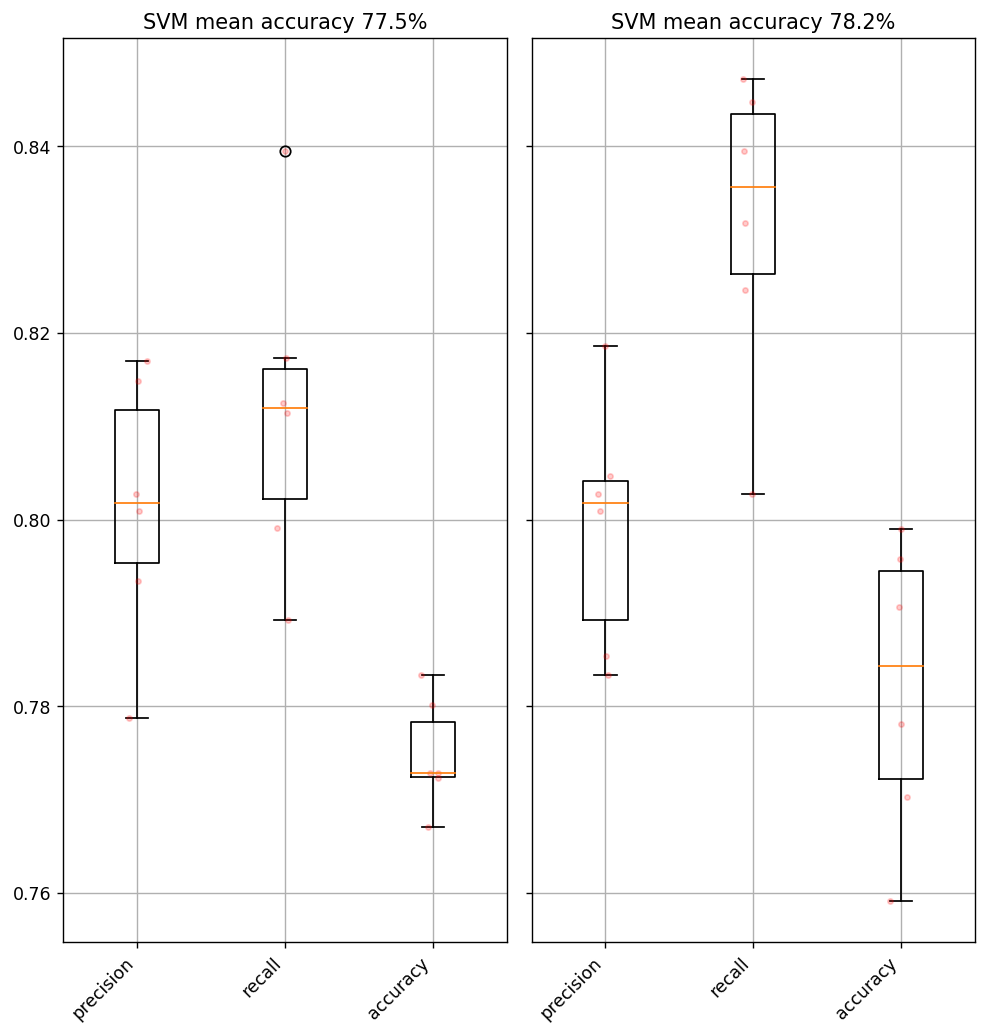

In [8]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

fig, axs = plt.subplots(1, len(clf_models[:2]),dpi=125,figsize=(8,8),sharey=True)              
lu.plot_model_output(clf_models[:2],  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
#fig.tight_layout()
#plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()

In [7]:
for model in clf_models:
    print(model["title"], model["auc"], np.mean(model["auc"]))

SVM [0.7805357142857143, 0.7696188340807174, 0.7621490130664442, 0.7737064739333838, 0.7563511050353156, 0.7655763906727174] 0.7679895885123821
SVM [0.7958653846153846, 0.7638452914798206, 0.7682096191270504, 0.7812701347452168, 0.7434495329232171, 0.7830579102092075] 0.7726163121833162
GB [0.7626236263736262, 0.7210482062780269, 0.7569919377258825, 0.7360422444463119, 0.6880838459785829, 0.7808887747238633] 0.7409464392543823
GB [0.7794505494505494, 0.7325952914798206, 0.7242285237698082, 0.7575146370843489, 0.692555251765778, 0.7917915346633558] 0.7463559647022767
Adaboost [0.7213049450549451, 0.7044002242152465, 0.7264386989157632, 0.7034344622797434, 0.6615117338801548, 0.7110483203470617] 0.7046897307821526


In [29]:
revectorize = True

X_exists = os.path.isfile(f'../data/X_{seen_df.shape[0]}.npz')

if revectorize is True or X_exists is False:
    print("running vectorisation again")
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=10, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("str"))   
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{seen_df.shape[0]}.npz', X)
else:
    print("loading feature matrix")
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz(f'../data/X_{seen_df.shape[0]}.npz')
        
X.shape

running vectorisation again


(2522, 8113)

In [32]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier


y = df['relevant']


from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=1)
    },
    {
        'title': 'SVM', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=10)
    },
    {
        'title': 'SVM', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=100)
    },
    {
        'title': 'SVM', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=1000)
    },
]

clf_models, df = lu.cross_validate_models(X, y, clf_models, seen_index, n_splits=6, df = df)

1
2
3
4
5
6


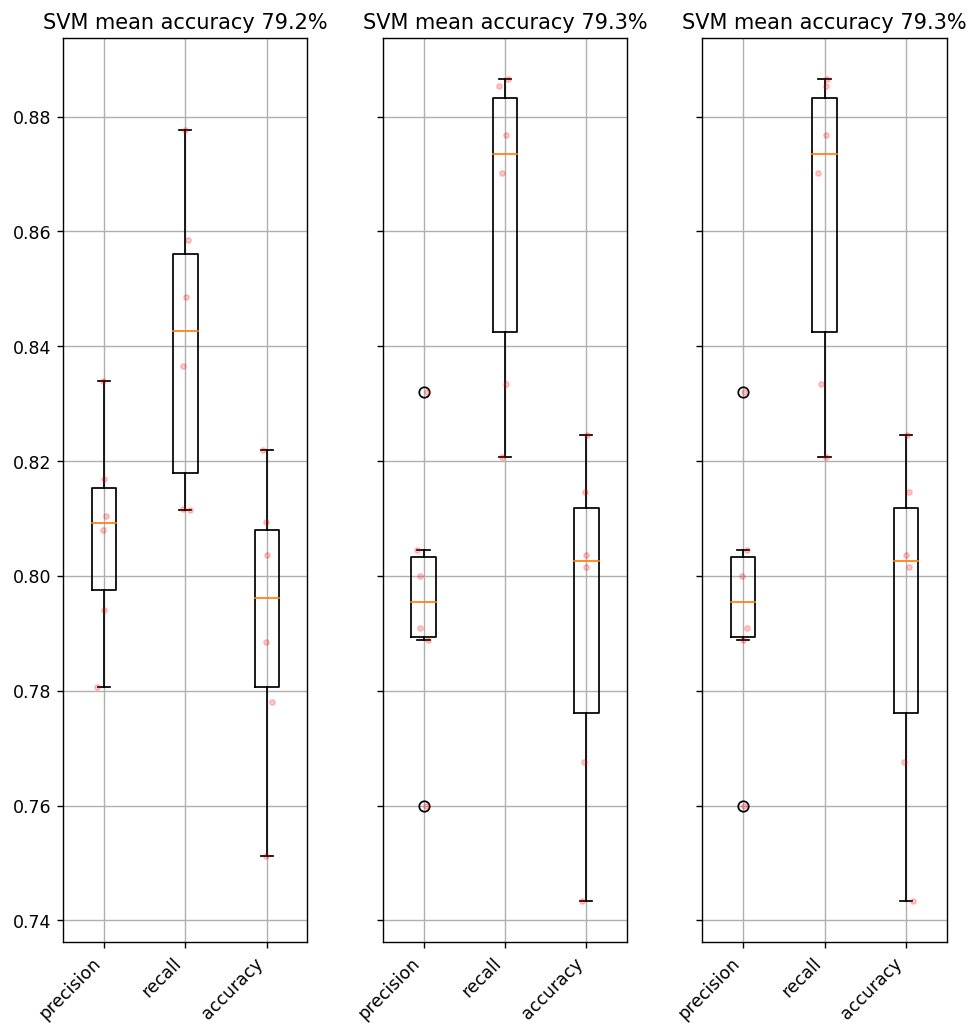

In [33]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

fig, axs = plt.subplots(1, len(clf_models),dpi=125,figsize=(8,8),sharey=True)              
lu.plot_model_output(clf_models,  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
#fig.tight_layout()
#plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()

In [ ]:
# 15 0.8 78 79
# 20 0.8 77.5 78.7
# 10 0.8 78.5 79.2
# 8  and 12, worse

In [36]:
hi_C = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=1000)
    },
    {
        'title': 'SVM', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=10000)
    },
]

hi_C, df = lu.cross_validate_models(X, y, hi_C, seen_index, n_splits=6, df = df)

1
2
3
4
5
6


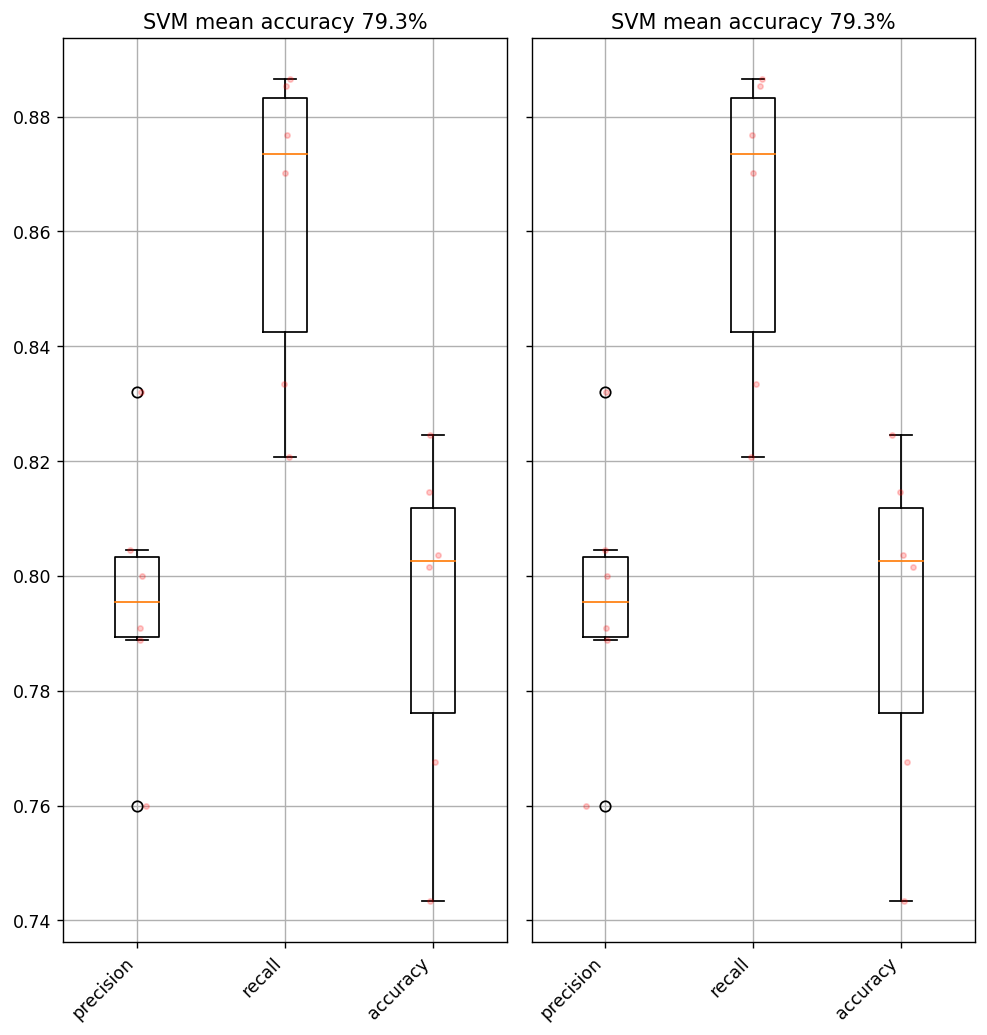

In [37]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

fig, axs = plt.subplots(1, len(hi_C),dpi=125,figsize=(8,8),sharey=True)              
lu.plot_model_output(hi_C,  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
#fig.tight_layout()
#plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()